## Investigating and Cleaning Covid-19 Data

### Importing Important Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
import sklearn.metrics

### Importing the Data

In [2]:
train = pd.read_csv("./data/train.csv")
train.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2,2,Arizona,04-12-2020,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
3,3,Arkansas,04-12-2020,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


In [3]:
train.isna().sum()

ID                         0
Province_State             0
Date                       0
Confirmed                  0
Deaths                     0
Recovered               1329
Active                     0
Incident_Rate              0
People_Tested              0
People_Hospitalized     2053
Mortality_Rate             0
Testing_Rate               0
Hospitalization_Rate    2053
dtype: int64

We see that there is a lot of missing data found in the People_Hospitalized, Recovered and Hospitalization_Rate columns. This would imply that either we fill these with certain values or we ignore these columns when training the data.

In [32]:
max_num_cases = train.groupby('Province_State')['Confirmed'].max()
max_num_cases = pd.Series.sort_values(max_num_cases, ascending=False)
print(max_num_cases.head(5))
print(max_num_cases.tail(5))

Province_State
California    712475
Texas         632739
Florida       623471
New York      434756
Georgia       270471
Name: Confirmed, dtype: int64
Province_State
New Hampshire    7275
Alaska           5263
Maine            4529
Wyoming          3850
Vermont          1624
Name: Confirmed, dtype: int64


We see that there is a lot of variation of the maximum number of cases attained in different states, maybe this means for better accuracy we should aggregate more data for each state and perform our alg on a per state basis. To see if the trends match (so some time seires alg will catch the general trend) lets compare the growth rate of California and Alaska

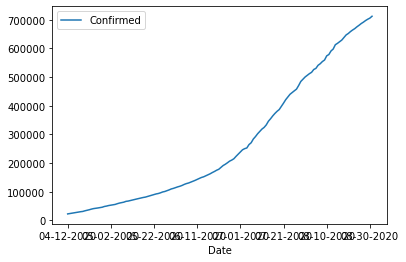

In [33]:
cal = train.loc[train['Province_State'] == 'California']
verm = train.loc[train['Province_State'] == 'Vermont']
cal.plot(x = "Date", y = "Confirmed")

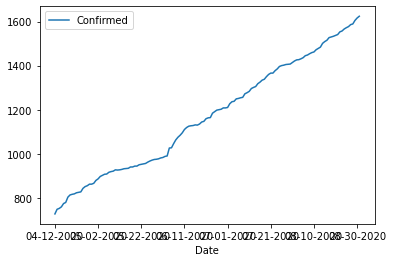

In [34]:
verm.plot(x = "Date", y = "Confirmed")

There seems to be a general trend of increase but the rate of increase are different so perhaps a batch approach to training the model seems better, (i.e. per state)

### Exploring trends

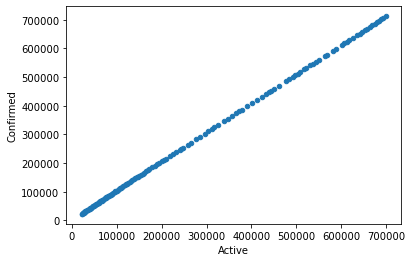

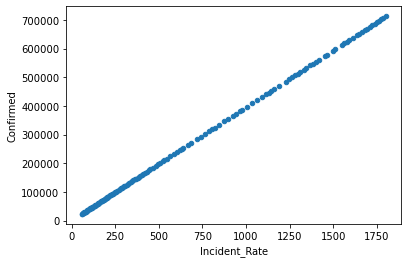

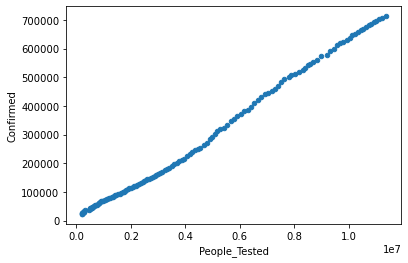

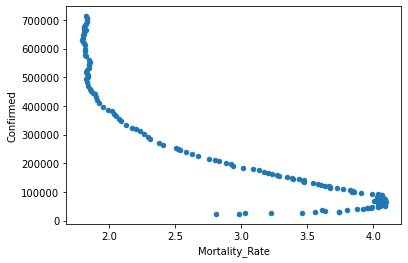

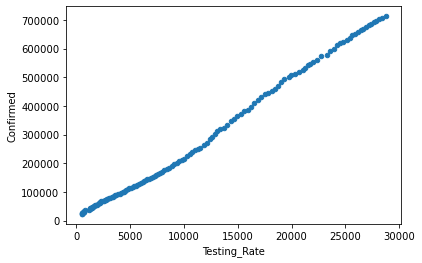

In [35]:
#Non missing columns first
cal.plot(x = 'Active', y = 'Confirmed', kind = 'scatter')
cal.plot(x = 'Incident_Rate', y = 'Confirmed', kind = 'scatter')
cal.plot(x = 'People_Tested', y = 'Confirmed', kind = 'scatter')
cal.plot(x = 'Mortality_Rate', y = 'Confirmed', kind = 'scatter')
cal.plot(x = 'Testing_Rate', y = 'Confirmed', kind = 'scatter')

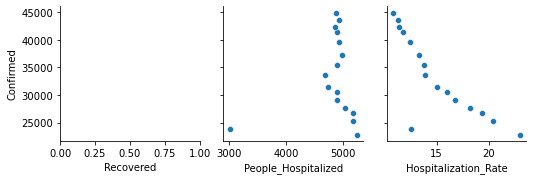

In [36]:
sns.pairplot(cal, y_vars = "Confirmed", x_vars = ["Recovered", "People_Hospitalized", "Hospitalization_Rate"])

Clearly the strongest linear relationships that can be achived appear from Incident_Rate, People_Tested and Testing_Rate so these features we should definitely include in our model. Mortality_Rate is interesting in the fact that it seems to be very high for less than 200000 cases and it tapers off as more cases come in, this does make sense of course logically as younger, healthier people get infected but modelling a trend requires some non-linear relationship to be made.

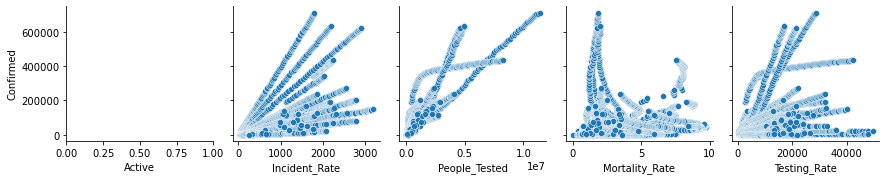

In [37]:
#Trying it with the full data set.
sns.pairplot(train, y_vars = "Confirmed", x_vars = ["Active",
                                                  "Incident_Rate", "People_Tested",
                                                  "Mortality_Rate", "Testing_Rate"])

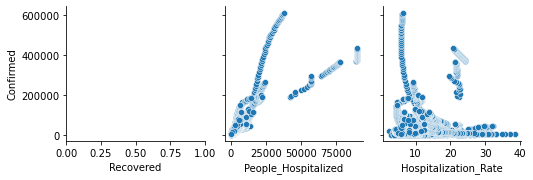

In [38]:
sns.pairplot(train, y_vars = "Confirmed", x_vars = ["Recovered","People_Hospitalized", "Hospitalization_Rate"])

Here we see some states are more linear than others. This again confirms that we should probably do this on a state by state basis. We can also see that People_Hospitalized works if and only if the data is not missing so much, and a somewhat sparse negative trend exists for Hospitalization_Rate. But since there are many missing values, it would not be much of a loss to ignore those values.

### Looking at missing values by State

In [39]:
#Trying to see which states have most missing values for those columns (maybe they stopped reporting)
num_missing = train.drop('Province_State', 1).isna().groupby(train.Province_State, sort=False).sum().reset_index()
num_missing[['Province_State','Recovered', 'People_Hospitalized', 'Hospitalization_Rate']]

,Province_State,Recovered,People_Hospitalized,Hospitalization_Rate
0,Alabama,35,4,4
1,Alaska,0,125,125
2,Arizona,2,5,5
3,Arkansas,0,5,5
4,California,137,126,126
5,Colorado,13,4,4
6,Connecticut,18,7,7
7,Delaware,0,126,126
8,Florida,137,4,4
9,Georgia,137,4,4


We can see for some states there is a lot less missing data than other states, maybe for the states for which the number of missing value is less than a threshold we can include People_Hospitalized or Hospitalization_Rate

### Looking at relationships between features

If the relationship between features is polynomial then a linear model will not work as well

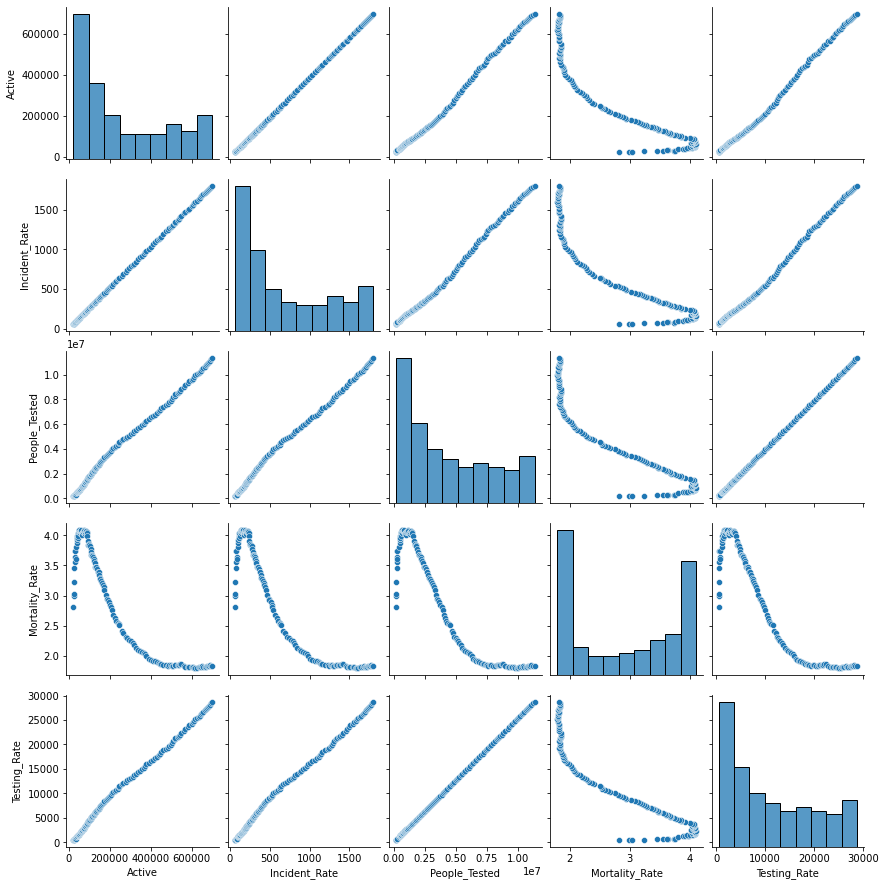

In [40]:
sns.pairplot(cal, vars = ["Active", "Incident_Rate", "People_Tested", "Mortality_Rate", "Testing_Rate"])

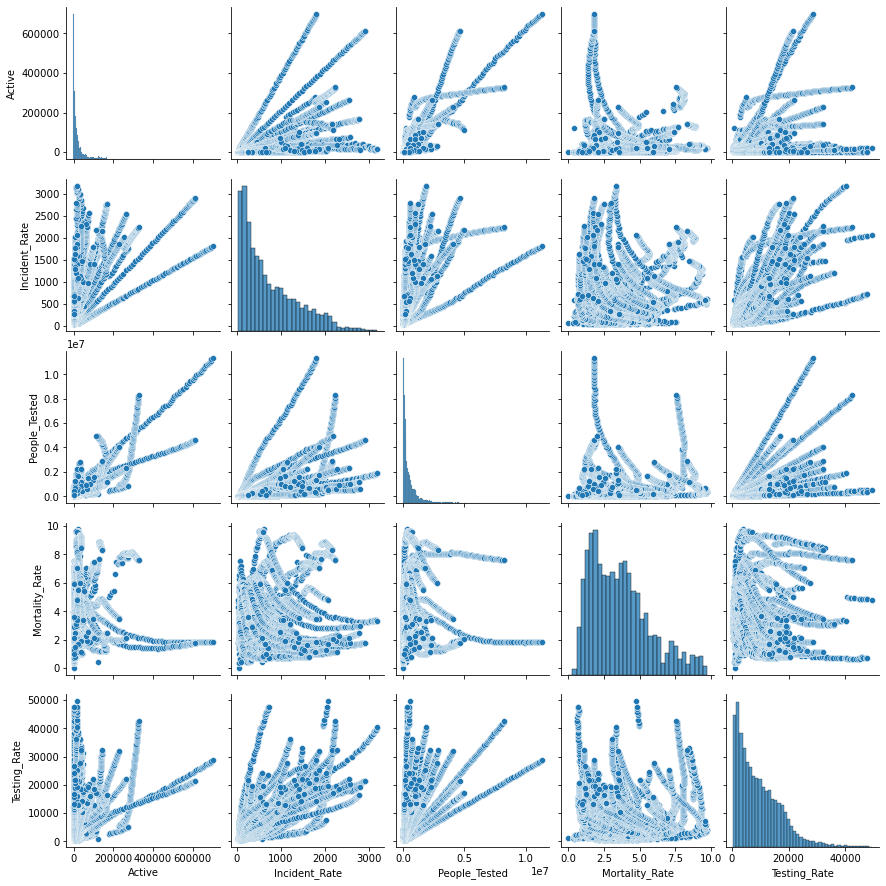

In [41]:
sns.pairplot(train, vars = ["Active", "Incident_Rate", "People_Tested", "Mortality_Rate", "Testing_Rate"])

We should probably not include mortality rate since it shows a similar non-linear trend for all like it did with the confirmed cases but will be hard to fit into a linear model. (These are for non missing columns). In the more general case for the whole dataset, we see that it is really muddled, so I feel it is best to be ignored.

### Test Model for California

In [42]:
wanted_cols = ['Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate', 'Confirmed']
cal_train = cal[wanted_cols]
cal_train

,Active,Incident_Rate,People_Tested,Testing_Rate,Confirmed
4,22155.0,58.137726,190328.0,485.423869,22795
54,23217.0,61.035048,190882.0,486.836823,23931
104,24589.0,64.669453,202208.0,515.723328,25356
154,25826.0,68.061564,216486.0,552.138790,26686
204,26721.0,70.589069,246400.0,628.433237,27677
...,...,...,...,...,...
6854,679144.0,1750.903765,10918415.0,27633.006121,691821
6904,684580.0,1764.985483,11010637.0,27866.407314,697385
6954,689144.0,1776.761586,11109630.0,28116.944977,702038
7004,693014.0,1786.664851,11231829.0,28426.213833,705951


In [43]:
cal_lin_train, cal_lin_test = sklearn.model_selection.train_test_split(cal_train, random_state = 11)
cal_lin_train_x = cal_lin_train[['Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate']]
cal_lin_train_y = cal_lin_train['Confirmed']
model = LinearRegression().fit(cal_lin_train_x, cal_lin_train_y)

In [44]:
cal_lin_test_y = cal_lin_test['Confirmed']
cal_lin_test_x = cal_lin_test[['Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate']]
predicted_y = model.predict(cal_lin_test_x)
predicted_y

array([712490.23422792, 578938.22058356, 103811.78124378, 430758.16988936,
       117216.88264533,  69306.57148287, 484898.8714401 , 506603.51602951,
        35519.86530474, 152309.1946934 , 346200.05409612, 638140.17751277,
       386891.13960166,  25366.85284843, 554388.49626891,  55878.08622504,
        70948.34887198,  41356.14407214,  39551.34567161,  46164.20398325,
       125743.27959836,  22787.21173223, 409287.00815509, 500544.03894122,
       629410.98199602,  44967.4238132 , 143386.43482011, 111951.69941944,
       354874.66449658, 452269.21885519, 175223.05379987, 421269.32096955,
       613104.01048841,  30529.09998138,  92536.61758919, 130620.33815661])

In [45]:
mse = sklearn.metrics.mean_squared_error(cal_lin_test_y, predicted_y)
mse

246.36055593552885

This is a pretty high MSE when using a linear model! Maybe normalizing the data will help

In [46]:
model2 = LinearRegression(normalize = True).fit(cal_lin_train_x, cal_lin_train_y)
predicted_y2 = model.predict(cal_lin_test_x)
predicted_y2

array([712490.23422792, 578938.22058356, 103811.78124378, 430758.16988936,
       117216.88264533,  69306.57148287, 484898.8714401 , 506603.51602951,
        35519.86530474, 152309.1946934 , 346200.05409612, 638140.17751277,
       386891.13960166,  25366.85284843, 554388.49626891,  55878.08622504,
        70948.34887198,  41356.14407214,  39551.34567161,  46164.20398325,
       125743.27959836,  22787.21173223, 409287.00815509, 500544.03894122,
       629410.98199602,  44967.4238132 , 143386.43482011, 111951.69941944,
       354874.66449658, 452269.21885519, 175223.05379987, 421269.32096955,
       613104.01048841,  30529.09998138,  92536.61758919, 130620.33815661])

In [47]:
mse2 = sklearn.metrics.mean_squared_error(cal_lin_test_y, predicted_y2)
mse2

246.36055593552885

Apparently OLS is invariant so normalization does not help. Maybe if we add more states it will help.

In [48]:
data_lin_train, data_lin_test = sklearn.model_selection.train_test_split(train, random_state = 11)
data_lin_train_x = data_lin_train[['Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate']]
data_lin_train_y = data_lin_train['Confirmed']
model = LinearRegression().fit(data_lin_train_x, data_lin_train_y)
data_lin_test_y = data_lin_test['Confirmed']
data_lin_test_x = data_lin_test[['Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate']]
predicted_y_full = model.predict(data_lin_test_x)
mse_full = sklearn.metrics.mean_squared_error(data_lin_test_y, predicted_y_full)
mse_full

621860469.627228

### NOPE! Doing it on the full dataset, as expected kinda really messes up since each state has its own rate of growth of covid, maybe a model other than linear regression would be better.

Since the competition uses MAPE, I will caluclate that instead

In [49]:
def MAPE(pred, actual):
    diff = np.abs(pred-actual)
    result = (1/len(pred)) * np.divide(diff, np.abs(actual))
    return np.sum(result)

In [50]:
mape = MAPE(predicted_y, cal_lin_test_y)
mape

0.00015069502576307294

### Ummm, maybe my function is wrong? Or I got a really low error for CA

In [51]:
mape_full = MAPE(predicted_y_full, data_lin_test_y)
mape_full

1.2551790779538587

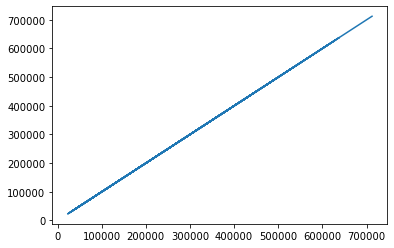

In [54]:
plt.plot(predicted_y, cal_lin_test_y)